 ### 1. Installazione e importazione delle librerie necessarie

In [ ]:
#!pip install mtcnn
#!pip install keras_vggface

import zipfile
import os
import cv2
import dlib
import pickle
import joblib
import operator

import numpy as np
from time import time

import matplotlib.pyplot as plt
from PIL import Image

import keras
from keras.preprocessing import image as kimage
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

from sklearn.neighbors import KDTree

from mtcnn.mtcnn import MTCNN

from google.colab import drive
drive.mount('/content/drive/')

DATASET_PATH = "/content/drive/My Drive/DSIM Project/retrieval/dataset/"
FACES_PATH = "/content/drive/My Drive/DSIM Project/retrieval/vip_faces/"

#per unzippare il dataset
#zip_ref = zipfile.ZipFile("/content/drive/My Drive/DSIM Project/retrieval/thumbnails_features_deduped_publish.zip", 'r')
#zip_ref.extractall("/content/drive/My Drive/DSIM Project/retrieval")
#zip_ref.close()

Using TensorFlow backend.


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### 2. Creazione delle immagini ritagliate 
Partendo dal dataset totale, è stato considerato un suo sottoinsieme composto da circa *600* soggetti, per un totale di circa *5,000* immagini, pari al 2.5\% delle immagini totali. Da queste immagini sono state create le immagini dei volti, attraverso il face detector *MTCNN()*, e successivamente salvate nella cartella *vip_faces*. Le immagini avranno forma 512x512 pixels.


In [ ]:
def create_cropped_faces_new(n_img):
  
  required_size=(512,512)
  mtcnnFaceDetector = MTCNN()

  for fold in os.listdir(DATASET_PATH):
    try:
      celebrities = []
      count = 0

      images_ = os.listdir(os.path.join(DATASET_PATH,fold))
      images_sort = sorted(images_, key=operator.itemgetter(1), reverse=True)

      for image in images_sort: 
        if image.endswith('.jpg') and count<n_img:
          count+=1
 
          try:
            subject = fold.replace(' ', '_')
            identity = subject + "_" + image

            if not os.path.isfile(os.path.join(FACES_PATH,identity)):
              #lettura dell'immagine
              img = cv2.imread(os.path.join(DATASET_PATH,fold,image))

              #face detector
              results = mtcnnFaceDetector.detect_faces(img)
              x1, y1, width, height = results[0]['box']
              x2, y2 = x1 + width, y1 + height

              #ritaglio dell'immagine
              face = img[y1:y2, x1:x2]
              face = cv2.resize(face, required_size, interpolation = cv2.INTER_AREA)
              face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)

              #salvataggio dell'immagine
              subject = fold.replace(' ', '_')
              identity = subject + "_" + image
              cv2.imwrite(FACES_PATH+"/"+identity, face)

          except:
            pass
    except:
      pass

In [ ]:
create_cropped_faces_new(n_img=10)  

### 3. Download della rete pre-trained : VGGFace
Al fine di estrapolare le features dalle immagini, è stata utilizzata una rete pre-addestrata *VGGFace*, basata sulla rete *ResNet50*. In particolare, come modalità di pooling è stato scelto "max", non sono stati inclusi i top layers e come input shape è stata utilizzata (512,512,3).

In [ ]:
net = VGGFace(include_top=False, weights='vggface', model='resnet50', pooling='max', input_shape=(512, 512, 3))

### 4. Estrazione delle features
Le features vengono estratte attraverso la rete VGGFace, partendo dalle immagini precedentemente ritagliate (512x512 pixels).

In [ ]:
# Feature dummy
def identity(image):
    return image

# Data loader
def load_data(feature_extractor=identity):

    paths = []
    features = []

    for fi,f in enumerate(sorted(os.listdir(FACES_PATH))):
        if f.endswith('.jpg'):
            # Memorizza percorso file
            cur_path = FACES_PATH + f
            paths.append(cur_path)
            
            # Carica file ed estraine le features
            image = kimage.load_img(cur_path, target_size=(512, 512))
            cur_features = feature_extractor(image)
            features.append(cur_features)

    features = np.array(features)
    return features, paths

In [ ]:
def neural_features(img):
    x = kimage.img_to_array(img)
    x = preprocess_input(x, version=2)
    x = np.expand_dims(x, axis=0)
    f = net.predict(x)
    return f.flatten()

In [ ]:
%time X_train, paths = load_data(feature_extractor=neural_features)

CPU times: user 2min 48s, sys: 40.6 s, total: 3min 28s
Wall time: 3min 27s


In [ ]:
# Dimensioni matrice di features estratte
X_train.shape

(5558, 2048)

### 5. Recupero delle immagini attraverso KDTree
Per il retrieval delle immagini è stato utlizzato l'algoritmo **KDTree** e come metrica la distanza **euclidea**. Il KDTree è una struttura di partizionamento dello spazio per organizzare i punti in uno spazio k-dimensionale.


In [ ]:
tree = KDTree(X_train, metric='euclidean')

Attraverso la funzione *find_similar_people()*, vengono riportate le immagini e le relative distanze dall'immagine target. Le immagini vengono successivamente salvate nelle appostite cartelle.

In [ ]:
def find_similar_pepole(name):

  retrieval_path = '/content/drive/My Drive/DSIM Project/retrieval/retrieved_images/'+ name 
  query_path = '/content/drive/My Drive/DSIM Project/retrieval/images_query/'+ name + '.jpg'

  query_image = cv2.imread(query_path)
  img_query = kimage.load_img(query_path)

  mtcnnFaceDetector = MTCNN()
  results = mtcnnFaceDetector.detect_faces(query_image)

  x1, y1, width, height = results[0]['box']
  x2, y2 = x1 + width, y1 + height
  # extract the face
  face = query_image[y1:y2, x1:x2]

  # Crop image 
  query_image = cv2.resize(face, (512,512), interpolation = cv2.INTER_AREA)
  query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)

  print('Name: ', name)
  plt.figure(figsize=(3,3))
  plt.imshow(query_image)
  plt.show()
  print(("-")*50, "\n")

  cv2.imwrite(retrieval_path+"/"+name+".jpg", query_image)

  query_image = np.asarray(query_image)
  
  query_features = neural_features(query_image)
  query_features = np.expand_dims(query_features, axis=0)

  dist, ind = tree.query(query_features, k=10)

  vip_list = os.listdir(FACES_PATH)

  for i in range(10):  

    img = cv2.imread(paths[ind[0][i]])
    subject = vip_list[ind[0][i]].split("_")
    pos = str(i+1)

    img_name = pos+"-"+subject[0]+"_"+subject[1]+"_("+ str(round(dist[0][i],2)) +").jpg"
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(retrieval_path+"/"+img_name, img)

    print(pos+".", subject[0],subject[1] ,"- distance:", dist[0][i])
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.show()

### 6. Risultati

#### 6.1 Federico

Name:  Federico


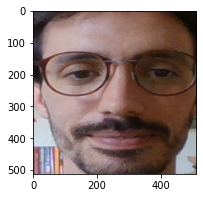

-------------------------------------------------- 

1. ayn rand - distance: 77.99406154586993


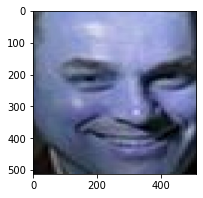

2. emiliana torrini - distance: 78.3706079776608


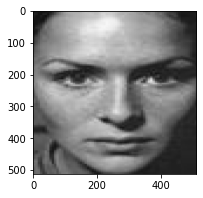

3. bill maher - distance: 78.43085611398632


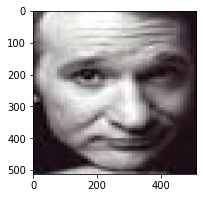

4. danny boyle - distance: 78.48645811398036


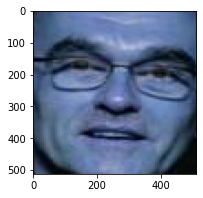

5. bela lugosi - distance: 78.60304928590915


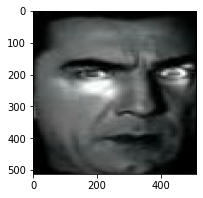

6. duke ellington - distance: 78.80217022753526


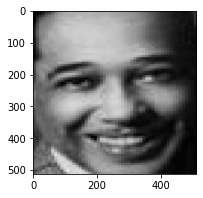

7. amitabh bachchan - distance: 78.8847439665431


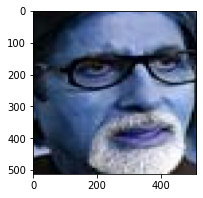

8. dierks bentley - distance: 78.93663904094676


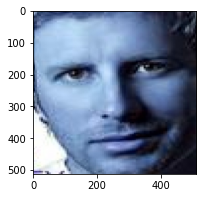

9. daniel radcliffe - distance: 79.0208936472208


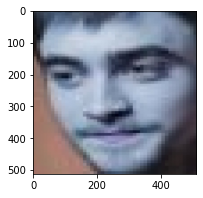

10. ethan hawke - distance: 79.42851029168607


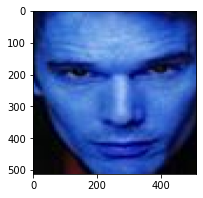

In [ ]:
find_similar_pepole('Federico')

#### 6.2 Davide

Name:  Davide


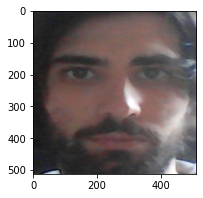

-------------------------------------------------- 

1. bela lugosi - distance: 55.69816803102738


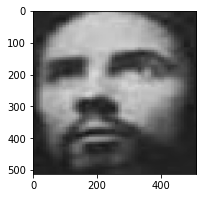

2. charles manson - distance: 57.87638539766223


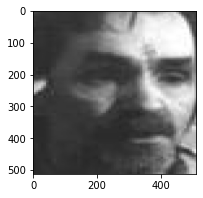

3. emiliana torrini - distance: 62.183352765961835


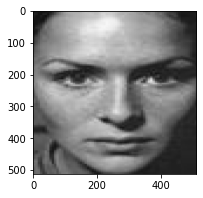

4. bill maher - distance: 62.559102574064866


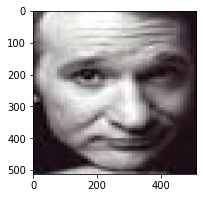

5. freddie prinze - distance: 62.897450139653934


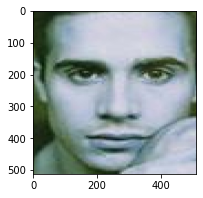

6. annasophia robb - distance: 63.30363050931723


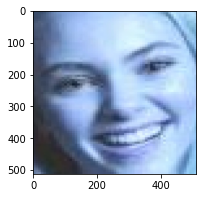

7. george carlin - distance: 63.37005354624947


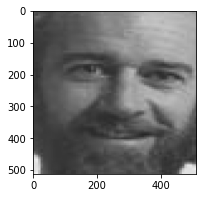

8. bruce springsteen - distance: 63.66323043684445


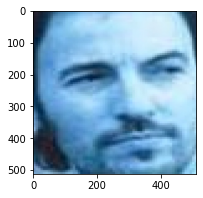

9. abigail breslin - distance: 63.97021792997682


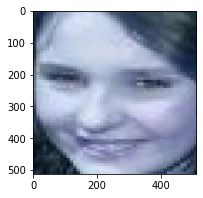

10. etta james - distance: 65.20759520897505


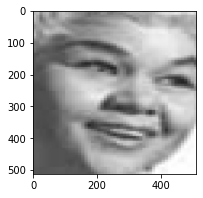

In [ ]:
find_similar_pepole('Davide')

#### 6.3 Anastasia

Name:  Anastasia


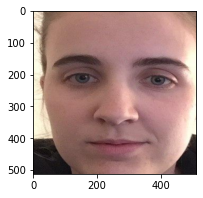

-------------------------------------------------- 

1. delta goodrem - distance: 67.3122384221518


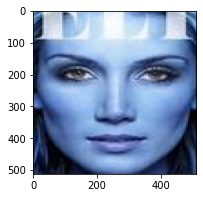

2. carrie underwood - distance: 69.2046791836821


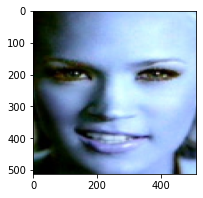

3. christie brinkley - distance: 69.30608506202783


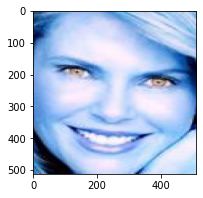

4. grace kelly - distance: 69.8100726167552


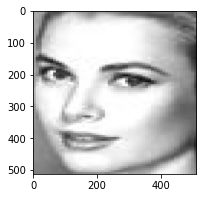

5. elizabeth taylor - distance: 69.87504922433075


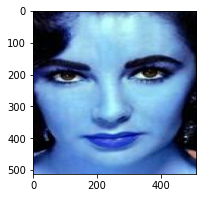

6. gemma ward - distance: 70.7695341059196


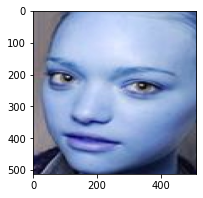

7. diya mirza - distance: 70.8440259253817


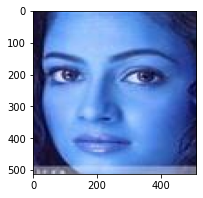

8. coco rocha - distance: 70.9087118266405


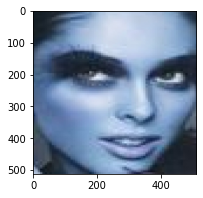

9. drew barrymore - distance: 71.01817886288067


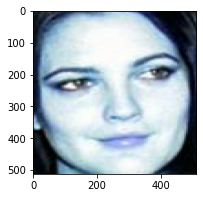

10. dionne warwick - distance: 71.56207915975516


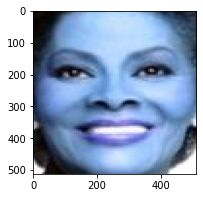

In [ ]:
find_similar_pepole('Anastasia')